In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
# Read dataset file
df = pd.read_csv('/ETH.csv')
df = df[['Price']]
df = df.dropna()
df

,Price
0,693.28
1,696.76
2,716.02
3,696.85
4,642.17
...,...
1822,1799.36
1823,1817.11
1824,1823.98
1825,1821.73


In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
# Normalize the data
mean = train_data.mean()
meant = test_data.mean()
meanv = val_data.mean()
std = train_data.std()
stdt = test_data.std()
stdv = val_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - meant) / stdt
val_data = (val_data - meanv) / stdv

In [5]:
# Prepare the data for CNN
window_size = 10

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data.values, window_size)
X_test, y_test = create_sequences(test_data.values, window_size)
X_val, y_val = create_sequences(val_data.values, window_size)


In [6]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
40/40 [==============================] - 10s 10ms/step - loss: 0.3105 - val_loss: 0.1195
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0982
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0916
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0834
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0802
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0724
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0668
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0651
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0611
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0618
Epoch 1

In [8]:
# Make predictions
y_pred = model.predict(X_test)
# Inverse transform the predictions
y_pred = y_pred * pd.Series(stdt).values[0] + pd.Series(meant).values[0]

12/12 [==============================] - 0s 3ms/step


In [9]:
# Make predictions
y_vpred = model.predict(X_val)
# Inverse transform the predictions
y_vpred = y_vpred * pd.Series(stdv).values[0] + pd.Series(meanv).values[0]

6/6 [==============================] - 0s 2ms/step


In [10]:
df

,Price
0,693.28
1,696.76
2,716.02
3,696.85
4,642.17
...,...
1822,1799.36
1823,1817.11
1824,1823.98
1825,1821.73


In [11]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# re make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
# re make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAPE:", test_mape)

Validation RMSE: 374.6103693423728
Testing RMSE: 1390.3484791564247
Validation MAPE: 20.110525254905845
Testing MAPE: 53.77732464497298
Validation MAE: 300.60155435984404
Testing MAPE: 53.77732464497298


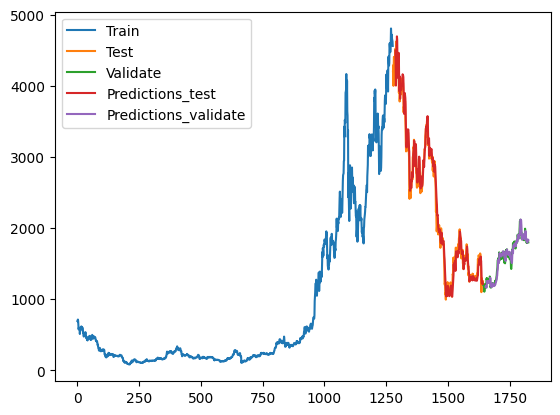

In [12]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index[-len(y_pred):], y_pred)
plt.plot(val_data.index[-len(y_vpred):], y_vpred)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate'])
plt.show()

In [13]:
y_val

array([1206.16, 1205.17, 1207.31, 1217.65, 1142.88, 1107.46, 1139.74,
       1185.79, 1203.77, 1198.12, 1205.15, 1193.38, 1167.73, 1216.55,
       1294.41, 1276.05, 1295.69, 1240.46, 1279.74, 1259.56, 1271.26,
       1231.04, 1280.29, 1262.86, 1266.62, 1263.42, 1275.02, 1320.76,
       1307.3 , 1266.32, 1166.7 , 1187.18, 1182.7 , 1167.8 , 1217.2 ,
       1213.85, 1217.57, 1220.03, 1220.46, 1218.69, 1227.65, 1211.6 ,
       1189.98, 1200.84, 1199.8 , 1195.67, 1200.52, 1213.93, 1214.57,
       1256.92, 1250.95, 1269.14, 1263.9 , 1288.38, 1320.51, 1335.13,
       1389.84, 1416.08, 1450.86, 1550.02, 1552.69, 1576.94, 1564.67,
       1511.31, 1551.62, 1659.98, 1625.53, 1627.03, 1626.53, 1556.15,
       1611.2 , 1602.55, 1597.6 , 1573.07, 1645.97, 1566.5 , 1585.27,
       1642.1 , 1641.71, 1663.79, 1666.9 , 1629.44, 1613.72, 1671.4 ,
       1650.99, 1545.35, 1513.82, 1538.34, 1515.44, 1505.84, 1555.46,
       1675.43, 1640.66, 1693.96, 1691.62, 1681.52, 1703.27, 1659.41,
       1643.39, 1650

In [14]:
y_vpred

array([[1176.7373],
       [1187.7537],
       [1188.4602],
       [1163.6119],
       [1165.0549],
       [1207.8647],
       [1258.7468],
       [1253.9424],
       [1236.4846],
       [1229.0066],
       [1245.0103],
       [1249.9089],
       [1233.4915],
       [1234.3895],
       [1250.4911],
       [1244.8043],
       [1255.6663],
       [1259.5436],
       [1272.0774],
       [1303.2   ],
       [1251.3442],
       [1188.1311],
       [1181.6116],
       [1175.402 ],
       [1177.4907],
       [1170.8131],
       [1205.325 ],
       [1207.7195],
       [1225.2615],
       [1214.8087],
       [1212.335 ],
       [1216.3588],
       [1207.5442],
       [1185.3331],
       [1188.3811],
       [1190.8182],
       [1191.467 ],
       [1193.9769],
       [1196.9382],
       [1208.0701],
       [1213.0863],
       [1239.7699],
       [1241.8822],
       [1254.4453],
       [1261.3071],
       [1282.4602],
       [1316.8289],
       [1333.2803],
       [1391.9486],
       [1418.0272],
